Download images of birds and non-birds

In [59]:
from duckduckgo_search import DDGS, AsyncDDGS
from fastcore.all import *

def search_images(term, max_images=30):
    results = DDGS().images(
        keywords=term,
        region="wt-wt",
        safesearch="off",
        size=None,
        color="color",
        type_image=None,
        layout=None,
        license_image=None,
        max_results=max_images,
    )
    
    # # async
    # results = AsyncDDGS().aimages(term, region='wt-wt', safesearch='off', max_results=20)
    list_of_urls = []
    for result in results:
        list_of_urls.append(result['image'])
    return list_of_urls

Searching for a bird photo and displaying the url

In [61]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

Downloading a bird image and storing it.

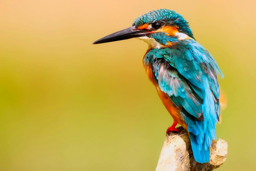

In [63]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
# dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))
im = Image.open(dest)
im.to_thumb(256,256)

Downloading forest photo

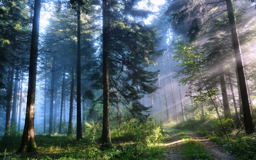

In [65]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

Downloads photos of birds and forest in preparation to train the model

In [69]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Checking for corrupted images

In [71]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

Preparing the model for training.

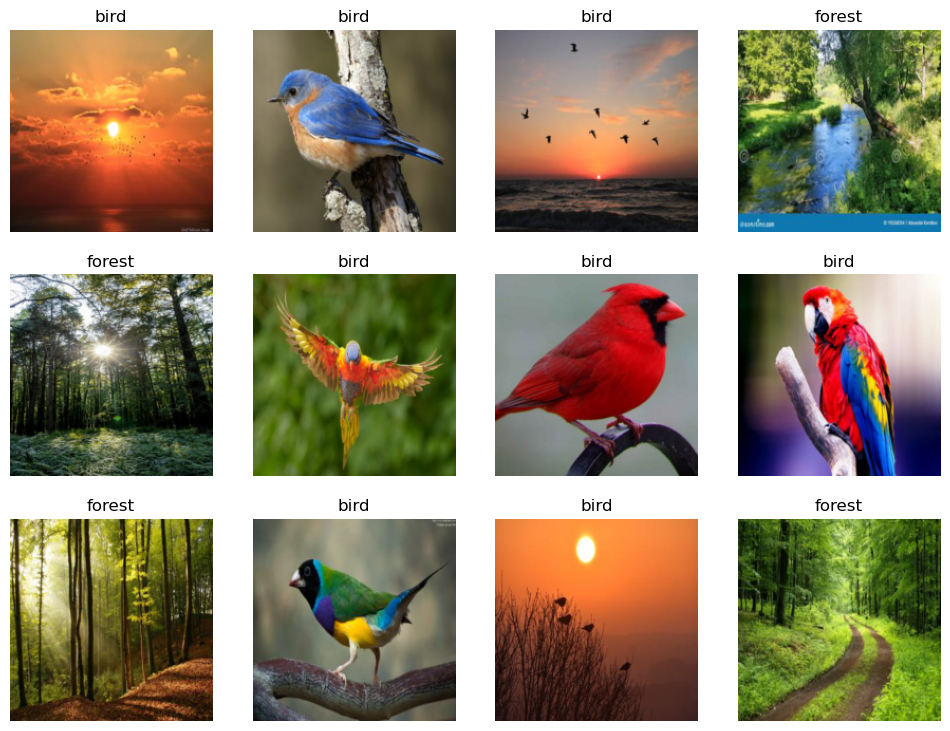

In [94]:
## Train model

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=12)



Training resnet18 model with our data

In [98]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.887015,0.662818,0.294118,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.113729,0.035886,0.029412,00:01
1,0.068625,0.016890,0.000000,00:01
2,0.054430,0.027465,0.029412,00:01
3,0.039717,0.035718,0.029412,00:01
4,0.032461,0.023176,0.000000,00:01


Testing if our bird.jpg is a bird

In [101]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9994
